# Decision Tree 決策樹
## 目錄
--- 
1. Introduction
2. 資料前處理
3. 模型建置
4. 模型評估
5. 模型解釋性
6. 參考資源
---

## 1. Introduction 
在資料分析當中，常見的形式通常可以大致分成分類或預測兩種，而當中各有各適合的模型。而今天要介紹的模型 - 決策樹，更是一個強大的模型，並且同時適用分類以及預測兩種不同的資料分析情境中。

決策樹的基本概念是將一群解的空間切割成不同大小的區段，並根據觀測值位於哪個區段進一步判定其屬於何種結果，最終會形成類似樹狀的結構圖。

每個機器學習的模型都有各自的優缺點，想當然我們的決策樹也不例外，但就我自身的角度而言，決策樹擁有了許多其他方法無法擁有的優點，以下用列點說明：
- 解釋性 (interpret)：因為決策樹每次的切分都可以透過人為判讀，因此具有一定的解釋能力，比起類神經網路的黑盒子（Blackbox），更能提供決策的解釋原因。
- 強健性（robustness）：決策樹對於一些噪音具有很好的抗性，不容易因為產生太大的偏差。
- 不需正規化：決策樹每次切割的重點都在於特徵的分佈而非特徵的值，因此不需要對於數值進行正規化處理。
- 特徵挑選：可以用來篩選出重要變數，可為一種 feature selection 的方法。
- 交互關係：決策樹每次切割都是遞迴切割，自然而然的可以處理 feature 間的交互作用關係，其他像是 linear 的方法就缺乏這個優點。

而如何建出決策樹，可以主要分做三個步驟，分別是挑選切分點、生成決策樹、修剪決策樹。每個步驟中亦有各自的方法，本次我們所使用的即是 CART 的方法

----
現在我們要使用 sklearn 中的一個資料集 - breast_cancer，用來示範決策樹模型的使用，該資料集用不同的照片轉數據的特徵來判斷該病患是否罹患乳癌（良性：benign（1），惡性：malignant (0)），該分析的資料屬於 Binary Classification。

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 載入資料集

In [2]:
breast_cancer = datasets.load_breast_cancer()

In [3]:
x = pd.DataFrame(breast_cancer.data, columns = breast_cancer.feature_names)
y = pd.DataFrame(breast_cancer.target, columns = ['target'])
data = pd.concat([x, y], axis = 1)

該資料中有 569 筆資料，且當中有 357 筆良性的資料以及 212 筆惡性的資料 從資料敘述來看，可以發現資料間彼此的維度差異相當大，然而，使用決策樹的好處之一就是因為每次決策樹的切割點都是按造特徵的分佈而非特徵的值，所以並不用進行標準化處理

In [4]:
data.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [5]:
data.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


檢查遺漏值

In [6]:
data.isnull().any().any()

False

## 2. 資料前處理

因為資料集中並沒有遺漏值的出現需要填補等，因此，我們在這個步驟僅對資料進行切分

- 原始資料列 569 被隨機切割為 80% 訓練資料集 (455筆) 與20%測試資料集 (114筆)。

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## 3. 模型建置

我們使用的是 sklearn 中的 decision tree 的演算法，簡單列點說明一下！

- 對所有參數和分割點進行評估，每次都找到最佳選擇的切分點
- 最佳的切分點指的是能使分割後的組內資料更為一致（pure）
- 橫量是否一致的方法是採用 gini index 來衡量
- 建模過程分做兩階段：生成樹、修剪樹

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

- criterion: 指的是使用何種方法進行計算切分點，若是 ID3 則使用 entropy，若是 CART 則使用 gini
- max_depth: 對於決策樹而言，樹的深度會決定資料是否 overfitting，越深的樹越容易 overfitting，因此，若要進行參數調整，可以針對該參數進行 cross-validation
- 我們簡單對樹的深度進行參數調整，並且用 10-fold cross-validation 來紀錄 score

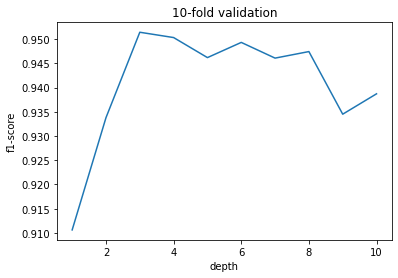

In [9]:
depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
score_list = []

for i in depth:
    clf = DecisionTreeClassifier(criterion = "gini", max_depth = i)
    score = cross_val_score(clf, x_train, y_train, cv=10, scoring='f1')
    score_list.append(sum(score) / len(score))
    
plt.plot(depth, score_list)
plt.xlabel("depth")
plt.ylabel('f1-score')
plt.title("10-fold validation")
plt.show()

由上圖我們可以選擇 depth = 3 時結果最好，因此訓練上我們使用該參數

In [10]:
clf_cv = DecisionTreeClassifier(criterion = "gini", max_depth = 3)
clf_cv.fit(x_train, y_train)
# 預測結果
y_pred = clf_cv.predict(x_test)

另外，我們也建立一個利用 entropy 的方式切分的決策樹

In [11]:
clf_entropy = DecisionTreeClassifier(criterion = "entropy", max_depth = 3)
clf_entropy.fit(x_train, y_train)
# 預測結果
y_pred_entropy = clf_entropy.predict(x_test)

## 4. 模型評估
利用 confusion matrix 、accuracy 、 recall 、 f1-score 來評估訓練好的分類器好壞

首先是 CART 的決策樹：

In [12]:
from sklearn.metrics import confusion_matrix,classification_report
print("CART Accuracy score:", clf_cv.score(x_test, y_test))

CART Accuracy score: 0.9385964912280702


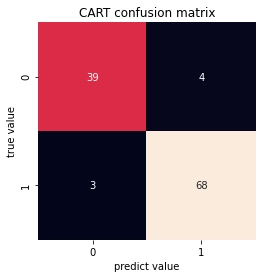

In [13]:
matric = confusion_matrix(y_test, y_pred)
sns.heatmap(matric,square=True,annot=True,cbar=False)
plt.xlabel("predict value")
plt.ylabel("true value")
plt.title("CART confusion matrix")
plt.show()

In [14]:
print("report:\n",classification_report(y_test, y_pred,labels=[1,0],target_names=["良性","惡性"])) 

report:
               precision    recall  f1-score   support

          良性       0.94      0.96      0.95        71
          惡性       0.93      0.91      0.92        43

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



再來是 ID3 的決策樹

In [15]:
print("Entropy Accuracy score:", clf_entropy.score(x_test, y_test))

Entropy Accuracy score: 0.9649122807017544


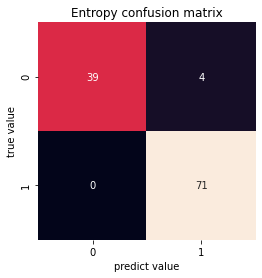

In [16]:
matric = confusion_matrix(y_test, y_pred_entropy)
sns.heatmap(matric,square=True,annot=True,cbar=False)
plt.xlabel("predict value")
plt.ylabel("true value")
plt.title("Entropy confusion matrix")
plt.show()

In [17]:
print("report:\n",classification_report(y_test, y_pred_entropy,labels=[1,0],target_names=["良性","惡性"])) 

report:
               precision    recall  f1-score   support

          良性       0.95      1.00      0.97        71
          惡性       1.00      0.91      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



## 5. 模型解釋性
前述有提到，決策樹類型的模型能夠提供一定能力的解釋能力，我們可以找出模型在預測時所認為重要的 feature，又或者是可以從樹的結構看出決策樹判斷的邏輯

In [18]:
# 重要 feature
important_feature = clf_cv.feature_importances_
print("important feature:")
print("----------------")
for i in range(len(important_feature)):
    if important_feature[i] != 0:
        print(breast_cancer.feature_names[i])

important feature:
----------------
mean concave points
radius error
concavity error
worst radius
worst texture
worst perimeter
worst concave points


In [19]:
from sklearn import tree

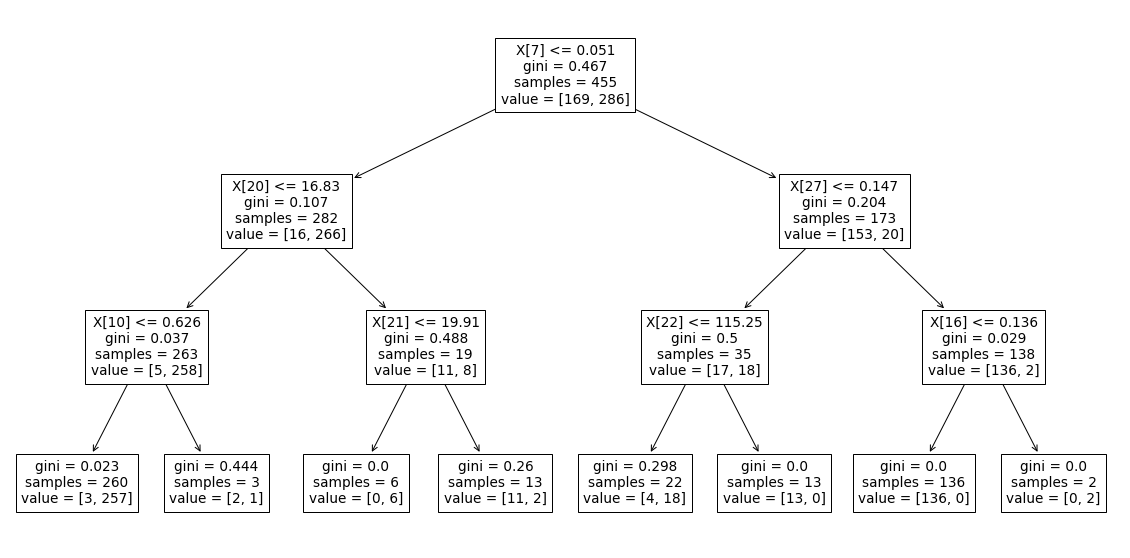

In [20]:
# 樹的結構
plt.figure(figsize = (20,10))
tree.plot_tree(clf_cv)
plt.show()

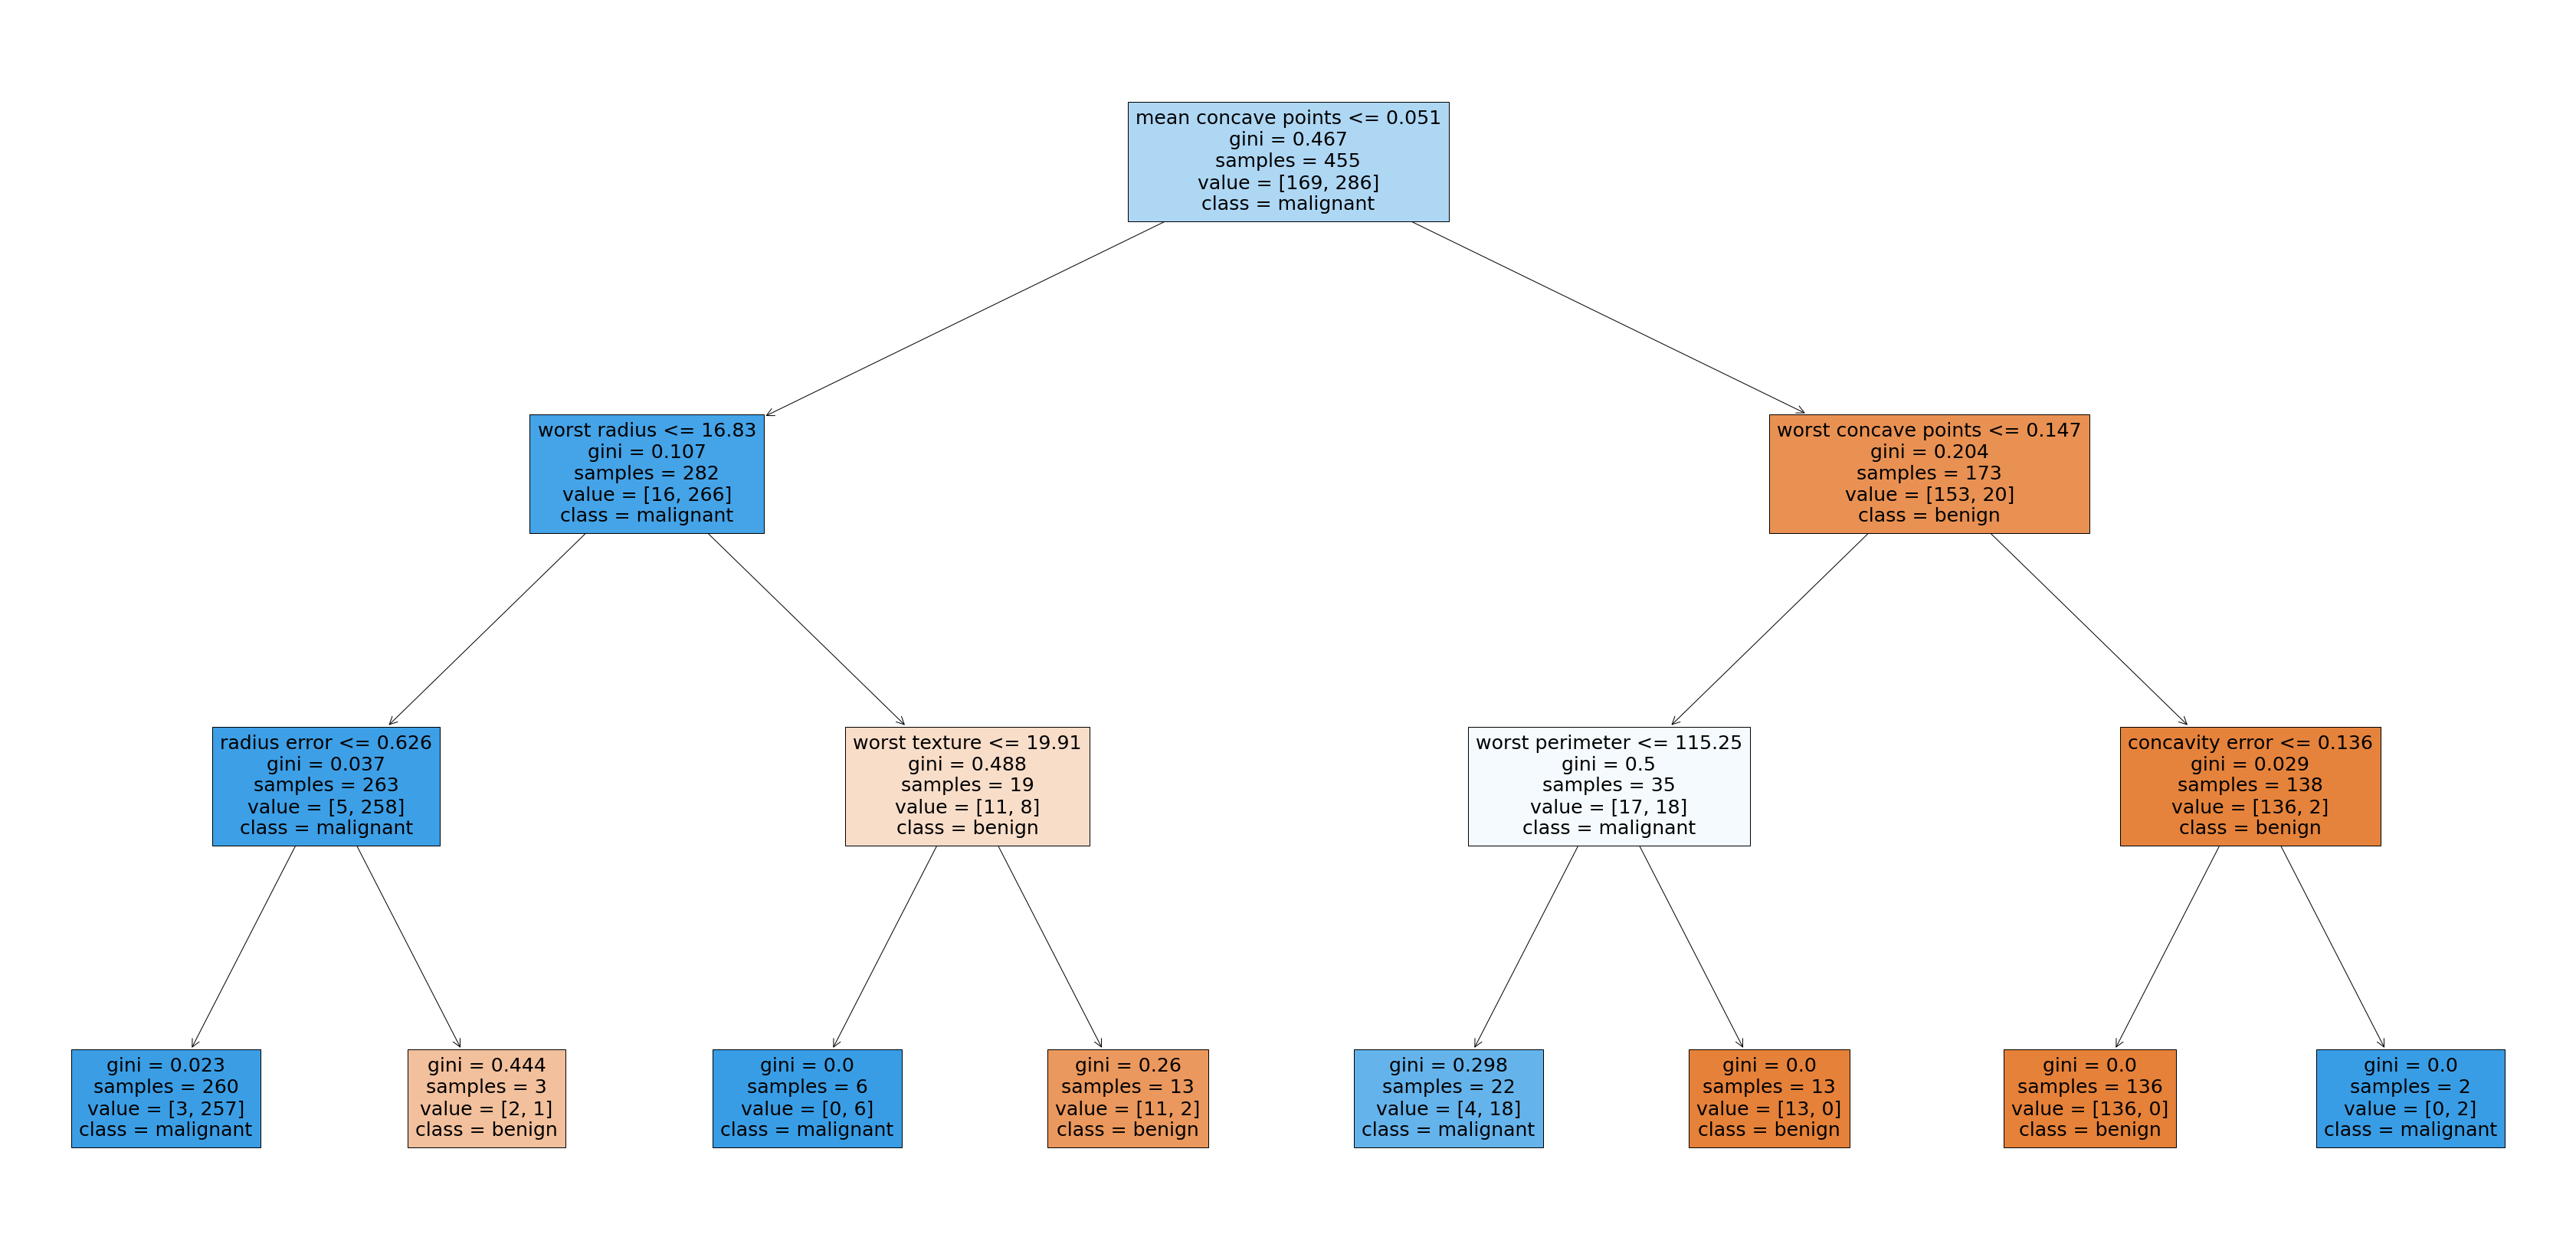

In [21]:
plt.figure(figsize = (60,30))
feature_name = breast_cancer.feature_names
class_name = ['benign', 'malignant']
tree.plot_tree(clf_cv,
               feature_names = feature_name, 
               class_names=class_name,
               filled = True);

細看樹的結構，就能夠發現從一開始樹進行分類的時候是對於哪個 feature 進行切割，值的大小為多少，透過這樣子的呈現就得到模型的可解釋性
此外，從這張圖來看，可以發現一開始模型在分的時候，先看了 "mean concave points"是否小於0.051，若是的話，就在往右下角的節點看，第二節點是確認是否 "worst concave points"小於0.145，以此類推，依此進行直到葉節點就能區分出模型判斷該資料為何種類別

## 6. 參考資源
- sklearn decision tree https://scikitlearn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- Decision Tree 決策樹 | CART, Conditional Inference Tree, RandomForest
https://www.jamleecute.com/decision-tree-cart-決策樹/
- R_programming - (8)決策樹（Decision Tree）
https://rpubs.com/allan811118/R_programming_08